<a href="https://colab.research.google.com/github/yxmauw/GA_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [ ]:
# upload files to working directory each runtime
!git clone https://github.com/yxmauw/GA_Capstone.git # has to be public repository

Cloning into 'GA_Capstone'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 691 (delta 13), reused 8 (delta 1), pack-reused 660
Receiving objects: 100% (691/691), 187.91 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (654/654), done.


In [ ]:
train_label = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
train_label.head(3)

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0


In [ ]:
# explore counts
train_label['Glaucoma'].value_counts()
# 482 negative, 168 positive for glaucoma (contains both train, validation images)
# total 650 images

0    482
1    168
Name: Glaucoma, dtype: int64

In [ ]:
# load example image
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])

JPEG
RGB
(3072, 2048)
[[1 3 0]
 [1 3 0]
 [1 3 0]
 ...
 [1 3 0]
 [1 3 0]
 [1 3 0]]


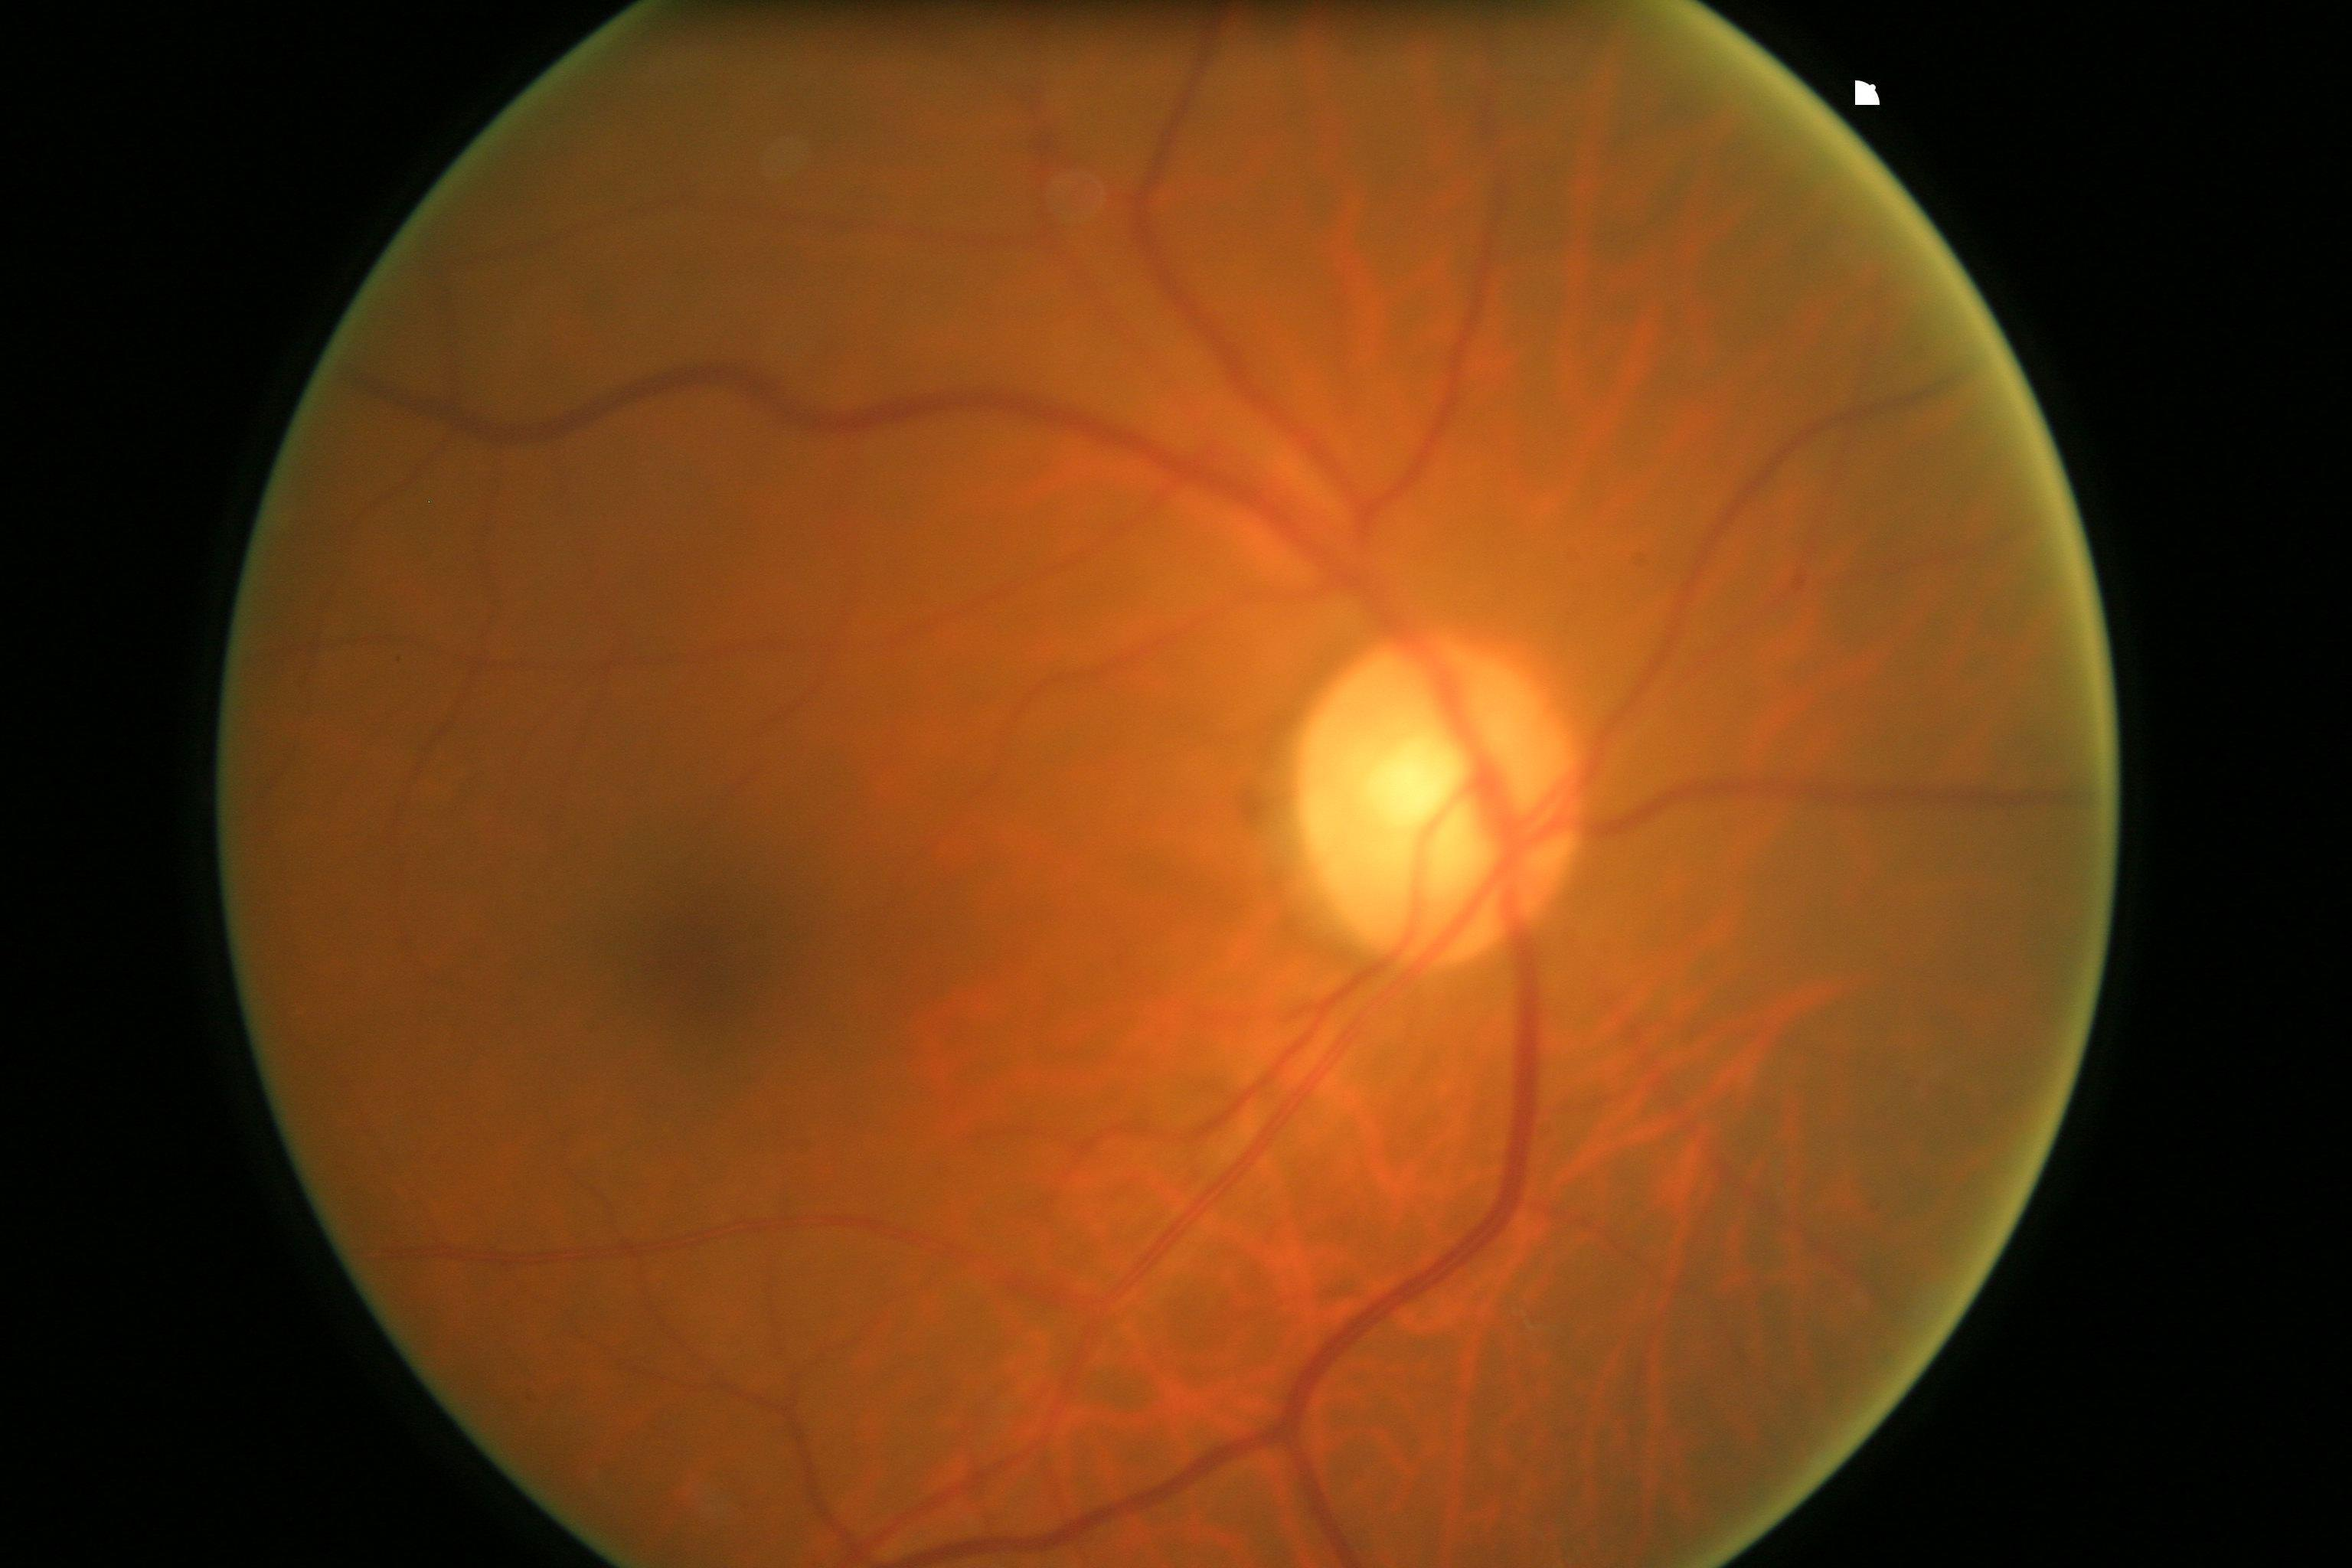

In [ ]:
#Import library
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=300, height=200)